In [1]:
#Libraries
import pandas as pd
import numpy as np
import random
from scipy.sparse import csr_matrix
import itertools
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
activity_train = pd.read_csv('activity_train.csv', header=None)
# Define your column headers
column_headers = ['Uniprot_IDs', 'ChEMBL_IDs', 'Activity']  
# Read the CSV file with custom headers
activity_train = pd.read_csv('activity_train.csv', names=column_headers)

activity_test_blanked = pd.read_csv('activity_test_blanked.csv', header=None)
# Define your column headers
column_headers = ['Uniprot_IDs', 'ChEMBL_IDs', 'Activity']  
# Read the CSV file with custom headers
activity_test_blanked = pd.read_csv('activity_test_blanked.csv', names=column_headers)

mol_bits = pd.read_pickle('mol_bits.pkl')


In [3]:
activity_train

,Uniprot_IDs,ChEMBL_IDs,Activity
0,O14842,CHEMBL207881,4
1,O14842,CHEMBL2022244,6
2,O14842,CHEMBL2022245,2
3,O14842,CHEMBL2022246,1
4,O14842,CHEMBL2022247,4
...,...,...,...
135706,Q9Y5Y4,CHEMBL4214909,6
135707,Q9Y5Y4,CHEMBL4218012,2
135708,Q9Y5Y4,CHEMBL4217503,7
135709,Q9Y5Y4,CHEMBL4204359,8


In [4]:
activity_test_blanked

,Uniprot_IDs,ChEMBL_IDs,Activity
0,O14842,CHEMBL2022258,0
1,O14842,CHEMBL2047161,0
2,O14842,CHEMBL2047163,0
3,O14842,CHEMBL2047168,0
4,O14842,CHEMBL2047169,0
...,...,...,...
4623,Q9Y5Y4,CHEMBL4208314,0
4624,Q9Y5Y4,CHEMBL4205421,0
4625,Q9Y5Y4,CHEMBL4207935,0
4626,Q9Y5Y4,CHEMBL4208884,0


In [5]:
#Create a sparse matrix with the mol_bits dataset and generate a subset for initial analysis

def create_sparse_matrix(data, num_rows):
    random.seed(42)  # Set a seed for reproducibility
    sampled_indices = random.sample(range(len(data)), num_rows)
    ChEMBL_IDs = [list(data.keys())[i] for i in sampled_indices]
    structural_features = [list(data.values())[i] for i in sampled_indices]

    # Find the number of unique features
    num_features = max(max(indices) for indices in structural_features) + 1

    # Prepare data for csr_matrix
    matrix_data = []
    rows = []
    cols = []

    for row, indices in enumerate(structural_features):
        rows.extend([row] * len(indices))
        cols.extend(indices)
        matrix_data.extend([1] * len(indices))

    # Create the sparse matrix
    sparse_matrix = csr_matrix((matrix_data, (rows, cols)), shape=(num_rows, num_features))
    
    return sparse_matrix, ChEMBL_IDs

In [6]:
#Subset of 1000 rows selected from the initial mol_bits dataset

sparse_matrix, ChEMBL_IDs = create_sparse_matrix(mol_bits, 1000)
dense_matrix = sparse_matrix.toarray()
dense_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0]], dtype=int32)

In [7]:
df_sparse_matrix = pd.DataFrame(dense_matrix, index=ChEMBL_IDs)

In [8]:
#Test the average Jaccard with different B and R to select the best parameters to apply to the full mol_bits dataset 

def MakeBucketsT(TDocs, perms, N, B, R, NB):
    Buckets = {}
    all_docs = set(range(N))
    for b in range(B):
        SIGS = np.zeros((N, R), dtype="int32")
        for r in range(R):
            perm = perms[b * R + r]
            L = all_docs.copy()
            i = 0
            while len(L) > 0:
                elem = perm[i]
                docs_found = TDocs[elem] & L
                if len(docs_found) > 0:
                    SIGS[list(docs_found), r] = i
                    L = L - docs_found
                i += 1
                if i == len(perm):
                    SIGS[list(L), r] = i
                    L = set()
        for d in range(N):
            bucket = hash(tuple(SIGS[d])) % NB
            Buckets.setdefault((b, bucket), set()).add(d)
    return Buckets

def LSHT(Data, B, R, NB=28934501):
    N, M = Data.shape
    DT = Data.T  # Transpose the matrix
    DataT = [set(np.where(DT[i] == 1)[0]) for i in range(M)]  # Adjust indexing for dense matrix
    P = B * R
    np.random.seed(3)
    perms = [np.random.permutation(M) for _ in range(P)]
    buckets = MakeBucketsT(DataT, perms, N, B, R, NB)
    return buckets

def compare_characteristics(df, proteins):
    subset = df.loc[proteins]
    num_columns_differ = (subset.iloc[0] != subset.iloc[1]).sum()
    total_columns = len(subset.columns)
    num_columns_match = total_columns - num_columns_differ

    # Calculate the number of shared 1s between the proteins
    shared_1s = ((subset.iloc[0] == 1) & (subset.iloc[1] == 1)).sum()

    # Calculate the total number of 1s if both proteins had the same characteristics
    total_1s = subset.iloc[0].sum() + subset.iloc[1].sum() - shared_1s

    return num_columns_differ, num_columns_match, shared_1s, total_1s

def jaccard_similarity(protein1, protein2):
    intersection = np.sum(np.minimum(protein1, protein2))
    union = np.sum(np.maximum(protein1, protein2))
    return intersection / union

def extract_similar_pairs(buckets, ChEMBL_IDs, df):
    similar_pairs = []
    for (b, buck), docs in buckets.items():
        combs = itertools.combinations(docs, 2)
        for i, j in combs:
            protein1 = df.iloc[i].values
            protein2 = df.iloc[j].values
            jaccard_sim = jaccard_similarity(protein1, protein2)
            
            num_differ, num_match, shared_1s, total_1s = compare_characteristics(df, [ChEMBL_IDs[i], ChEMBL_IDs[j]])
            similar_pairs.append((ChEMBL_IDs[i], ChEMBL_IDs[j], num_differ, num_match, shared_1s, total_1s, jaccard_sim))
    return similar_pairs


# Vary B and R
Bs = [10, 20, 30, 40, 80, 90, 100]
Rs = [4, 8, 16, 20, 24, 28]

jaccard_values = []
similar_pairs_all = []   
        
for B in Bs:
    for R in Rs:
        buckets = LSHT(dense_matrix, B, R)
        similar_pairs = extract_similar_pairs(buckets, ChEMBL_IDs, df_sparse_matrix)
        jaccard_avg = sum(pair[-1] for pair in similar_pairs) / len(similar_pairs)
        jaccard_values.append((B, R, jaccard_avg))
        
        # Add B and R to each pair
        for pair in similar_pairs:
            similar_pairs_all.append(pair + (B, R))
        
        

# Extracting values for plotting
B_values = [val[0] for val in jaccard_values]
R_values = [val[1] for val in jaccard_values]
jaccard_avg_values = [val[2] for val in jaccard_values]

# Create DataFrame for all pairs with Jaccard similarity included
df_similar_pairs = pd.DataFrame(similar_pairs_all, columns=['Molecule 1', 'Molecule 2', 'Characteristics Differ', 'Total Match', 'Shared Characteristics', 'Total Characteristics', 'Jaccard Similarity', 'B','R'])

# Create DataFrame for average Jaccard similarity for different B and R values
df_jaccard_avg = pd.DataFrame(jaccard_values, columns=['B', 'R', 'Average Jaccard Similarity'])

Jaccard Similarity of a subset of 1000 molecules


,Molecule 1,Molecule 2,Characteristics Differ,Total Match,Shared Characteristics,Total Characteristics,Jaccard Similarity,B,R
0,CHEMBL4586090,CHEMBL3949250,139,1909,21,160,0.131250,10,4
1,CHEMBL3597592,CHEMBL3597598,20,2028,55,75,0.733333,10,4
2,CHEMBL426656,CHEMBL379838,54,1994,44,98,0.448980,10,4
3,CHEMBL161743,CHEMBL350817,43,2005,86,129,0.666667,10,4
4,CHEMBL3644332,CHEMBL3644344,0,2048,150,150,1.000000,10,4
...,...,...,...,...,...,...,...,...,...
47024,CHEMBL522987,CHEMBL492117,3,2045,72,75,0.960000,100,28
47025,CHEMBL3646889,CHEMBL3646859,14,2034,133,147,0.904762,100,28
47026,CHEMBL3644332,CHEMBL3644344,0,2048,150,150,1.000000,100,28
47027,CHEMBL598444,CHEMBL597009,0,2048,79,79,1.000000,100,28


Average Jaccard Similarity of a subset of 1000 molecules according with different B (Number of Bands) and R (Number of Rows per Band)


,B,R,Average Jaccard Similarity
0,10,4,0.410358
1,10,8,0.818805
2,10,16,0.965684
3,10,20,0.980180
4,10,24,0.986473
5,10,28,0.964112
6,20,4,0.406086
7,20,8,0.827506
8,20,16,0.961190
9,20,20,0.974998


Average Jaccard Similarity of a subset of 1000 molecules


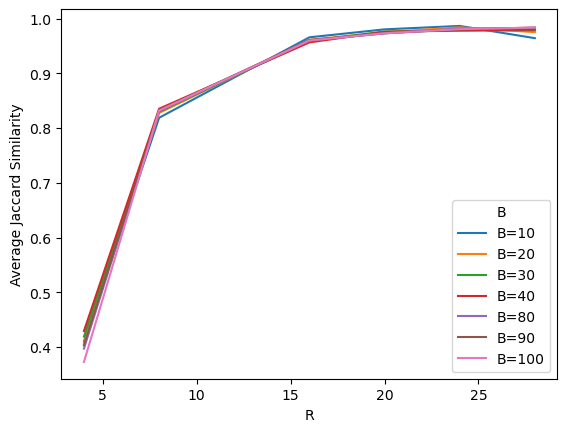

In [9]:
print("Jaccard Similarity of a subset of 1000 molecules")
display(df_similar_pairs)

print("Average Jaccard Similarity of a subset of 1000 molecules according with different B (Number of Bands) and R (Number of Rows per Band)")
display(df_jaccard_avg)

print("Average Jaccard Similarity of a subset of 1000 molecules")
fig, ax = plt.subplots()
for B in Bs:
    B_jaccard_values = [jaccard_avg_values[i] for i in range(len(jaccard_values)) if jaccard_values[i][0] == B]
    ax.plot(Rs, B_jaccard_values, label=f"B={B}")

ax.set_xlabel('R')
ax.set_ylabel('Average Jaccard Similarity')
ax.legend(title='B')

In [10]:
def create_sparse_matrix(data):
    ChEMBL_IDs = list(data.keys())
    structural_features = list(data.values())

    # Find the number of unique features
    num_features = max(max(indices) for indices in structural_features) + 1

    # Prepare data for csr_matrix
    matrix_data = []
    rows = []
    cols = []

    for row, indices in enumerate(structural_features):
        rows.extend([row] * len(indices))
        cols.extend(indices)
        matrix_data.extend([1] * len(indices))

    # Create the sparse matrix
    sparse_matrix = csr_matrix((matrix_data, (rows, cols)), shape=(len(ChEMBL_IDs), num_features))
    
    return sparse_matrix, ChEMBL_IDs

In [11]:
sparse_matrix, ChEMBL_IDs = create_sparse_matrix(mol_bits)
dense_matrix_full = sparse_matrix.toarray()
dense_matrix_full

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [12]:
df_full = pd.DataFrame(dense_matrix_full, index=ChEMBL_IDs)
df_full

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
CHEMBL2022243,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL2022244,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL2022245,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL2022246,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
CHEMBL2022247,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL4218012,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
CHEMBL4217503,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL4205802,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
CHEMBL4204359,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [13]:
def MakeBucketsT(TDocs, perms, N, B, R, NB):
    Buckets = {}
    all_docs = set(range(N))
    for b in range(B):
        SIGS = np.zeros((N, R), dtype="int32")
        for r in range(R):
            perm = perms[b * R + r]
            L = all_docs.copy()
            i = 0
            while len(L) > 0:
                elem = perm[i]
                docs_found = TDocs[elem] & L
                if len(docs_found) > 0:
                    SIGS[list(docs_found), r] = i
                    L = L - docs_found
                i += 1
                if i == len(perm):
                    SIGS[list(L), r] = i
                    L = set()
        for d in range(N):
            bucket = hash(tuple(SIGS[d])) % NB
            Buckets.setdefault((b, bucket), set()).add(d)
    return Buckets

def LSHT(Data, B, R, NB=28934501):
    N, M = Data.shape
    DT = Data.T  # Transpose the matrix
    DataT = [set(np.where(DT[i] == 1)[0]) for i in range(M)]  # Adjust indexing for dense matrix
    P = B * R
    np.random.seed(3)
    perms = [np.random.permutation(M) for _ in range(P)]
    buckets = MakeBucketsT(DataT, perms, N, B, R, NB)
    return buckets

def compare_characteristics(df, proteins):
    subset = df.loc[proteins]
    num_columns_differ = (subset.iloc[0] != subset.iloc[1]).sum()
    total_columns = len(subset.columns)
    num_columns_match = total_columns - num_columns_differ

    shared_1s = ((subset.iloc[0] == 1) & (subset.iloc[1] == 1)).sum()
    total_1s = subset.iloc[0].sum() + subset.iloc[1].sum() - shared_1s

    return num_columns_differ, num_columns_match, shared_1s, total_1s

def jaccard_similarity(protein1, protein2):
    intersection = np.sum(np.minimum(protein1, protein2))
    union = np.sum(np.maximum(protein1, protein2))
    return intersection / union

def extract_similar_pairs(buckets, ChEMBL_IDs, df, B, R):
    similar_pairs = []
    for (b, buck), docs in buckets.items():
        combs = itertools.combinations(docs, 2)
        for i, j in combs:
            protein1 = df.iloc[i].values
            protein2 = df.iloc[j].values
            jaccard_sim = jaccard_similarity(protein1, protein2)
            
            num_differ, num_match, shared_1s, total_1s = compare_characteristics(df, [ChEMBL_IDs[i], ChEMBL_IDs[j]])
            similar_pairs.append((ChEMBL_IDs[i], ChEMBL_IDs[j], num_differ, num_match, shared_1s, total_1s, jaccard_sim, B, R))
            
    return similar_pairs

# Define different values for R
R_values = [28, 24, 20, 16, 8]
B = 80

# Collect results from all R values
all_similar_pairs = []

for R in R_values:
    buckets = LSHT(dense_matrix_full, B, R)
    similar_pairs = extract_similar_pairs(buckets, ChEMBL_IDs, df_full, B, R)
    all_similar_pairs.extend(similar_pairs)

# Create DataFrame with all results
df_similar_pairs = pd.DataFrame(all_similar_pairs, columns=['Molecule 1', 'Molecule 2', 'Characteristics Differ', 'Total Match', 'Shared Characteristics', 'Total Characteristics', 'Jaccard Similarity', 'B', 'R'])


In [14]:
df_similar_pairs

,Molecule 1,Molecule 2,Characteristics Differ,Total Match,Shared Characteristics,Total Characteristics,Jaccard Similarity,B,R
0,CHEMBL2022577,CHEMBL2047149,0,2048,86,86,1.000000,80,28
1,CHEMBL2022577,CHEMBL2047150,0,2048,86,86,1.000000,80,28
2,CHEMBL2047149,CHEMBL2047150,0,2048,86,86,1.000000,80,28
3,CHEMBL2047151,CHEMBL2047152,0,2048,87,87,1.000000,80,28
4,CHEMBL2047151,CHEMBL2047153,0,2048,87,87,1.000000,80,28
...,...,...,...,...,...,...,...,...,...
6871875,CHEMBL4205421,CHEMBL4212706,25,2023,70,95,0.736842,80,8
6871876,CHEMBL4212838,CHEMBL4203572,28,2020,75,103,0.728155,80,8
6871877,CHEMBL4208457,CHEMBL4205047,24,2024,75,99,0.757576,80,8
6871878,CHEMBL4205627,CHEMBL4216735,34,2014,77,111,0.693694,80,8


In [22]:
df_similar_pairs.to_csv('df_similar_pairs.csv', index=False)

In [16]:
def find_most_similar_molecule(activity_test_blanked, df_similar_pairs):
    # Initialize an empty list to store the results
    results = []

    # Iterate over each row in the activity_test_blanked dataframe
    for index, row in activity_test_blanked.iterrows():
        chembl_id = row['ChEMBL_IDs']
        
        # Find rows in df_similar_pairs where the molecule matches
        similar_pairs = df_similar_pairs[(df_similar_pairs['Molecule 1'] == chembl_id) | (df_similar_pairs['Molecule 2'] == chembl_id)]
        
        if not similar_pairs.empty:
            # Sort by Jaccard Similarity to get the most similar molecule
            similar_pairs = similar_pairs.sort_values(by='Jaccard Similarity', ascending=False).iloc[0]
            
            # Determine the most similar molecule (different from the original)
            most_similar_molecule = similar_pairs['Molecule 1'] if similar_pairs['Molecule 1'] != chembl_id else similar_pairs['Molecule 2']
            jaccard_similarity = similar_pairs['Jaccard Similarity']
            
            results.append([chembl_id, most_similar_molecule, jaccard_similarity])
        else:
            # If no similar molecule is found, append None
            results.append([chembl_id, None, None])
    
    # Create a new dataframe with the results
    similar_molecules_df = pd.DataFrame(results, columns=['Original Molecule', 'Most Similar Molecule', 'Jaccard Similarity'])
    
    return similar_molecules_df


In [17]:
similar_molecules_df = find_most_similar_molecule(activity_test_blanked, df_similar_pairs)
similar_molecules_df

,Original Molecule,Most Similar Molecule,Jaccard Similarity
0,CHEMBL2022258,CHEMBL2022247,0.825000
1,CHEMBL2047161,CHEMBL2047154,0.797980
2,CHEMBL2047163,CHEMBL2022576,0.675926
3,CHEMBL2047168,CHEMBL2047169,0.779817
4,CHEMBL2047169,CHEMBL2047168,0.779817
...,...,...,...
4623,CHEMBL4208314,CHEMBL4213245,1.000000
4624,CHEMBL4205421,CHEMBL4217130,1.000000
4625,CHEMBL4207935,CHEMBL4212838,0.793814
4626,CHEMBL4208884,CHEMBL4205627,0.803738


In [21]:
similar_molecules_df.to_csv('similar_molecules_df.csv', index=False)

In [18]:
def fill_activity_scores(activity_test_blanked, similar_molecules_df, activity_train):
    # Merge the similar_molecules_df with the activity_train to get the activity scores
    merged_df = similar_molecules_df.merge(activity_train, left_on='Most Similar Molecule', right_on='ChEMBL_IDs', how='left')
    
    # Fill the Activity column in the activity_test_blanked dataframe
    for index, row in activity_test_blanked.iterrows():
        similar_molecule = similar_molecules_df.loc[similar_molecules_df['Original Molecule'] == row['ChEMBL_IDs'], 'Most Similar Molecule'].values[0]
        if pd.notna(similar_molecule):
            activity_score = merged_df.loc[merged_df['Most Similar Molecule'] == similar_molecule, 'Activity'].values[0]
            activity_test_blanked.at[index, 'Activity'] = activity_score
    
    return activity_test_blanked

In [19]:
activity_test_filled = fill_activity_scores(activity_test_blanked, similar_molecules_df, activity_train)
activity_test_filled

,Uniprot_IDs,ChEMBL_IDs,Activity
0,O14842,CHEMBL2022258,4.0
1,O14842,CHEMBL2047161,5.0
2,O14842,CHEMBL2047163,7.0
3,O14842,CHEMBL2047168,NaN
4,O14842,CHEMBL2047169,NaN
...,...,...,...
4623,Q9Y5Y4,CHEMBL4208314,8.0
4624,Q9Y5Y4,CHEMBL4205421,3.0
4625,Q9Y5Y4,CHEMBL4207935,9.0
4626,Q9Y5Y4,CHEMBL4208884,4.0


In [20]:
activity_test_filled.to_csv('activity_test_filled.csv', index=False)